# IMO - Zadanie 4

Autorzy: Dariusz Max Adamski, Sławomir Gilewski

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import multiprocessing as mp
from time import time
from copy import deepcopy
plt.rc('figure', figsize=(9, 5))

In [2]:
def index(xs, e):
    try:
        return xs.index(e)
    except:
        return None
        
def find_node(cycles, a):
    i = index(cycles[0], a)
    if i is not None: return 0, i
    i = index(cycles[1], a)
    if i is not None: return 1, i
    print(cycles)
    assert False, f'City {a} must be in either cycle'
    
def remove_at(xs, sorted_indices):
    for i in reversed(sorted_indices):
        del(xs[i])

def reverse(xs, i, j):
    n = len(xs)
    d = (j - i) % n
    #print(d)
    for k in range(abs(d)//2+1):
        a, b = (i+k)%n, (i+d-k)%n
        #print(a, '<->', b)
        xs[a], xs[b] = xs[b], xs[a]

In [3]:
def distance(a, b):
    return np.round(np.sqrt(np.sum((a - b)**2)))

def read_instance(path):
    coords = pd.read_csv(path, sep=' ', names=['n','x','y'], skiprows=6, skipfooter=1, engine='python')
    cities = coords.drop(columns=['n']).values
    ns = np.arange(len(cities))
    cities = np.array([[distance(cities[i], cities[j]) for j in ns] for i in ns])
    return cities, coords

def draw_path(coords, path, color='blue'):
    cycle = path + [path[0]]
    for i in range(len(cycle) - 1):
        a, b = cycle[i], cycle[i+1]
        plt.plot([coords.x[a], coords.x[b]], [coords.y[a], coords.y[b]], color=color)

def plot_solution(coords, solution):
    path1, path2 = solution
    draw_path(coords, path1, color='green')
    draw_path(coords, path2, color='red')
    plt.scatter(coords.x, coords.y, color='black')
    
def cycle_score(cities, path):
    cycle = path + [path[0]]
    return sum(cities[cycle[i], cycle[i+1]] for i in range(len(cycle) - 1))

def score(cities, paths):
    return cycle_score(cities, paths[0]) + cycle_score(cities, paths[1])

In [4]:
def delta_insert(cities, path, i, city):
    a, b = path[i - 1], path[i]
    return cities[a, city] + cities[city, b] - cities[a, b]

def solve_regret(args):
    cities, start = args
    t0 = time()
    n = cities.shape[0]
    remaining = list(range(n))
    a, b = start, np.argmax(cities[start,:])
    remaining.remove(a)
    remaining.remove(b)
    paths = [[a], [b]]
    while remaining:
        for path in paths:
            scores = np.array([[delta_insert(cities, path, i, v) for i in range(len(path))] for v in remaining])
            best_city_idx = None
            if scores.shape[1] == 1:
                best_city_idx = np.argmin(scores)
            else:
                regret = np.diff(np.partition(scores, 1)[:,:2]).reshape(-1)
                weight = regret - 0.37*np.min(scores, axis=1)
                best_city_idx = np.argmax(weight)
                
            best_city = remaining[best_city_idx]
            best_insert = np.argmin(scores[best_city_idx])
            path.insert(best_insert, best_city)
            remaining.remove(best_city)
    return time() - t0, paths

def solve_regret_init(cities, paths, remaining):
    t0 = time()
    while remaining:
        for path in paths:
            scores = np.array([[delta_insert(cities, path, i, v) for i in range(len(path))] for v in remaining])
            best_city_idx = None
            if scores.shape[1] == 1:
                best_city_idx = np.argmin(scores)
            else:
                regret = np.diff(np.partition(scores, 1)[:,:2]).reshape(-1)
                weight = regret - 0.37*np.min(scores, axis=1)
                best_city_idx = np.argmax(weight)
                
            best_city = remaining[best_city_idx]
            best_insert = np.argmin(scores[best_city_idx])
            path.insert(best_insert, best_city)
            remaining.remove(best_city)
    return time() - t0, paths

def random_solution(n, seed=None):
    remaining = list(range(n))
    random.seed(seed)
    random.shuffle(remaining)
    return remaining[:n//2], remaining[n//2:]

In [5]:
def insert_move(moves, move):
    delta_x = move[0]
    for i, x in enumerate(moves):
        delta_y = x[0]
        if delta_x < delta_y:
            moves.insert(i, move)
            return
        elif delta_x == delta_y:
            return
    moves.append(move)

def has_edge(cycle, a, b):
    for i in range(len(cycle) - 1):
        x, y = cycle[i], cycle[i+1]
        if (a, b) == (x, y): return +1
        if (a, b) == (y, x): return -1
        
    x, y = cycle[-1], cycle[0]
    if (a, b) == (x, y): return +1
    if (a, b) == (y, x): return -1
    return 0

def any_has_edge(cycles, a, b):
    for i in range(2):
        status = has_edge(cycles[i], a, b)
        if status != 0: return i, status
    return None, 0

def delta_swap_node(D, x1, y1, z1, x2, y2, z2):
    return D[x1,y2] + D[z1,y2] - D[x1,y1] - D[z1,y1] + D[x2,y1] + D[z2,y1] - D[x2,y2] - D[z2,y2]

def make_swap_node(cities, cycles, cyc1, i, cyc2, j, calc_delta=True):
    C1, C2 = cycles[cyc1], cycles[cyc2]
    D = cities
    n, m = len(C1), len(C2)
    x1, y1, z1 = C1[(i-1)%n], C1[i], C1[(i+1)%n]
    x2, y2, z2 = C2[(j-1)%m], C2[j], C2[(j+1)%m]
    delta = delta_swap_node(cities, x1, y1, z1, x2, y2, z2) if calc_delta else 0
    move = delta, SWAP_NODE, cyc1, cyc2, x1, y1, z1, x2, y2, z2
    return delta, move

def delta_swap_edge(cities, a, b, c, d):
    if a == d or a == b or a == c or b == c or b == d or c == d: return 1e8
    return cities[a, c] + cities[b, d] - cities[a, b] - cities[c, d]

def gen_swap_edge_2(cities, cycle, i, j, calc_delta=True):
    n = len(cycle)
    nodes = cycle[i], cycle[(i+1)%n], cycle[j], cycle[(j+1)%n]
    return (delta_swap_edge(cities, *nodes), *nodes) if calc_delta else (0, *nodes)

def delta_swap_edge_2(cities, cycle, i, j):
    return gen_swap_edge_2(cities, cycle, i, j)[0]

def gen_swap_edge(n):
    return [(i, (i+d)%n) for i in range(n) for d in range(2, n-1)]

def gen_swap_node(n, m):
    return [(i, j) for i in range(n) for j in range(m)]


def init_moves(cities, cycles):
    moves = []
    for k in range(2):
        cycle = cycles[k]
        n = len(cycle)
        for i, j in gen_swap_edge(n):
            delta, a, b, c, d = gen_swap_edge_2(cities, cycle, i, j)
            if delta<0: 
                moves.append((delta, SWAP_EDGE, a, b, c, d))
    for i, j in gen_swap_node(len(cycles[0]), len(cycles[1])):
        delta, move = make_swap_node(cities, cycles, 0, i, 1, j)
        if delta<0: 
            moves.append(move)
    return moves

def get_first_edge_swap(cities, cycles, better):
    for k in random.sample(range(2), 2):
        cycle = cycles[k]
        n = len(cycle)
        candidates = gen_swap_edge(n)
        random.shuffle(candidates)
        for i, j in candidates:
            delta, a, b, c, d = gen_swap_edge_2(cities, cycle, i, j, calc_delta=better)
            if not (delta >= 0 and better):
                return (delta, SWAP_EDGE, a, b, c, d)
    return None
    
def get_first_node_swap(cities, cycles, better):
    candidates = gen_swap_node(len(cycles[0]), len(cycles[1]))
    random.shuffle(candidates)
    for i, j in candidates:
        delta, move = make_swap_node(cities, cycles, 0, i, 1, j, calc_delta=better)
        if not (delta >= 0 and better): 
            return move
    return None
        
def get_move(cities, cycles, calc_delta=True):
    moves = [get_first_edge_swap, get_first_node_swap]
    move_order = random.sample(range(2), 2)
    move = moves[move_order[0]](cities, cycles, calc_delta)
    if move is None: 
        move = moves[move_order[1]](cities, cycles, calc_delta)
    return move


SWAP_EDGE, SWAP_NODE = range(2)
def apply_move(cycles, move):
    kind = move[1]
    if kind == SWAP_EDGE:
        _, _, a, _, c, _ = move
        (c1, i), (c2, j) = find_node(cycles, a), find_node(cycles, c)
        #print('swap edge', c1, i, c2, j, move[0])
        #assert c1 == c2, 'Cannot swap edges between cycles'
        cycle = cycles[c1]
        n = len(cycle)
        reverse(cycle, (i+1)%n, j)
    elif kind == SWAP_NODE:
        _, _, c1, c2, _, a, _, _, b, _ = move
        i, j = cycles[c1].index(a), cycles[c2].index(b)
        #print('swap node', c1, i, c2, j, move[0])
        #assert c1 != c2, 'Cannot swap nodes in the same cycle'
        cycles[c1][i], cycles[c2][j] = cycles[c2][j], cycles[c1][i]
    else:
        assert False, 'Invalid move type'

In [6]:
class SearchSteepest:
    def __init__(self, cities):
        self.cities = cities
    
    def __call__(self, cycles):
        cycles = deepcopy(cycles)
        start = time()
        while True:
            moves = init_moves(self.cities, cycles)
            if not moves: break
            move = min(moves, key=lambda x: x[0])
            apply_move(cycles, move)
        return time() - start, cycles

In [7]:
class SearchGreedy:
    def __init__(self, cities):
        self.cities = cities
    
    def __call__(self, cycles, inplace=False):
        if not inplace:
            cycles = deepcopy(cycles)
        start = time()
        while True:
            move = get_move(self.cities, cycles)
            if move is None: break
            apply_move(cycles, move)
        return time() - start, cycles

In [8]:
def compute_results():
    n = 200
    instances = [f'kroA{n}.tsp', f'kroB{n}.tsp']
    score_results = []
    time_results = []
    
    for file in instances:
        cities, coords = read_instance(file)
        solve = solve_regret
        times, init_solutions = zip(*mp.Pool().map(solve, [(cities, i) for i in range(n)]))
        scores = [score(cities, x) for x in init_solutions]
        
        score_results.append(dict(file=file, search="regret", min=int(min(scores)), mean=int(np.mean(scores)), max=int(max(scores))))
        time_results.append(dict(file=file, search="regret", min=float(min(times)), mean=float(np.mean(times)), max=float(max(times))))
        best_idx = np.argmin(scores)
        best = init_solutions[best_idx]
        print(f'file: {file}, search: regret, score: {scores[best_idx]}')
        plot_solution(coords, best)
        plt.show()
        
        for local_search in [SearchGreedy(cities)]:
            rand_solutions = [random_solution(n) for _ in range(100)]
            times, solutions = zip(*mp.Pool().map(local_search, rand_solutions))
            #times, solutions = zip(*[local_search(x) for x in rand_solutions])
            scores = [score(cities, x) for x in solutions]
            best_idx = np.argmin(scores)
            best = solutions[best_idx]
            print(f'file: {file}, search: {type(local_search).__name__}, score: {scores[best_idx]}')
            plt.subplots()
            plot_solution(coords, best)
            plt.show()

            score_results.append(dict(file=file, search=type(local_search).__name__, min=int(min(scores)), mean=int(np.mean(scores)), max=int(max(scores))))
            time_results.append(dict(file=file, search=type(local_search).__name__, min=float(min(times)), mean=float(np.mean(times)), max=float(max(times))))
        
    return pd.DataFrame(score_results), pd.DataFrame(time_results)

scores, times = compute_results()

FileNotFoundError: [Errno 2] No such file or directory: 'kroA200.tsp'

In [9]:
scores

NameError: name 'scores' is not defined

In [11]:
times

,file,search,min,mean,max
0,kroA200.tsp,regret,0.404008,0.663997,0.998724
1,kroA200.tsp,SearchGreedy,4.234824,8.431070,10.852510
2,kroB200.tsp,regret,0.397499,0.659828,1.001276
3,kroB200.tsp,SearchGreedy,4.261897,7.932245,10.035539


In [12]:
class MSLS:
    def __init__(self, cities, Algorithm):
        self.cities = cities
        self.n = len(cities)
        self.solve = Algorithm
    
    def __call__(self, iterations = 100):
        start = time()
        random_cycles = [random_solution(self.n) for i in range(iterations)]
        times, local_cycles = zip(*[self.solve(cycles, inplace=True) for cycles in random_cycles])
        scores = [score(self.cities, cycles) for cycles in local_cycles]
        return time() - start, local_cycles[np.argmin(scores)]

In [13]:
class ILS:
    def __init__(self, cities, Perturbation, Algorithm = SearchGreedy, with_local=True):
        self.cities = cities
        self.n = len(cities)
        self.perturbation = Perturbation
        self.solve = Algorithm
        self.with_local = with_local
    
    def __call__(self, time_limit):
        start = time()
        random_cycles = random_solution(self.n)
        _, best_cycles = self.solve(random_cycles)
        best_score = score(self.cities, best_cycles)
        while time()-start < time_limit:
            cycles = deepcopy(best_cycles)
            cycles = self.perturbation(self.cities, cycles)
            if self.with_local:
                _, cycles = self.solve(cycles, inplace=True)
            new_score = score(self.cities, cycles)
            if new_score < best_score:
                best_cycles = cycles
                best_score = new_score
        return time() - start, best_cycles
    
class SmallPerturbation:
    def __init__(self, n_moves=10):
        self.n_moves = n_moves
    
    def __call__(self, cities, cycles):
        for move in range(self.n_moves):
            move = get_move(cities, cycles, calc_delta=False)
            apply_move(cycles, move)
        return cycles
    
class BigPerturbation:
    def __init__(self, moves_fraction=0.2):
        self.moves_fraction = moves_fraction
    
    def __call__(self, cities, cycles):
        to_destroy = int(self.moves_fraction*len(cities)/2)
        
        remaining = []
        for cycle in cycles:
            n = len(cycle)
            destroy_begin = random.randint(0, n - 1)
            remaining.extend(cycle[destroy_begin : destroy_begin + to_destroy])
            cycle[destroy_begin : destroy_begin + to_destroy] = []

            if destroy_begin + to_destroy > n:
                remaining.extend(cycle[0 : destroy_begin + to_destroy - n])
                cycle[0 : destroy_begin + to_destroy - n] = []
    
        _, cycles = solve_regret_init(cities, cycles, remaining)
        
        return cycles

file: kroA200.tsp, search: MSLS, score: 34812.0


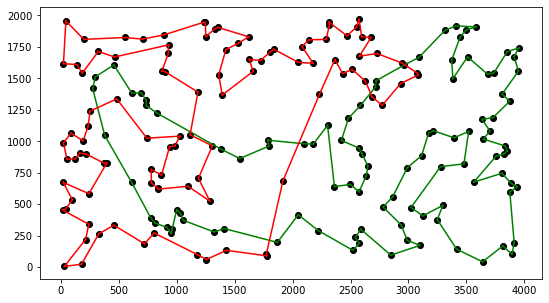

file: kroA200.tsp, perturbation: SmallPerturbation, search: ILS, with_local: True, score: 32375.0


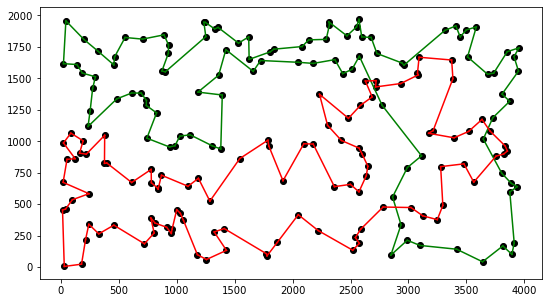

file: kroA200.tsp, perturbation: BigPerturbation, search: ILS, with_local: True, score: 30611.0


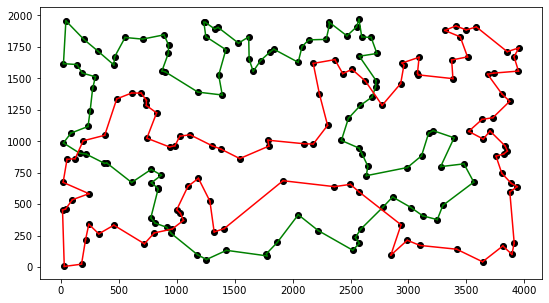

file: kroA200.tsp, perturbation: BigPerturbation, search: ILS, with_local: False, score: 31065.0


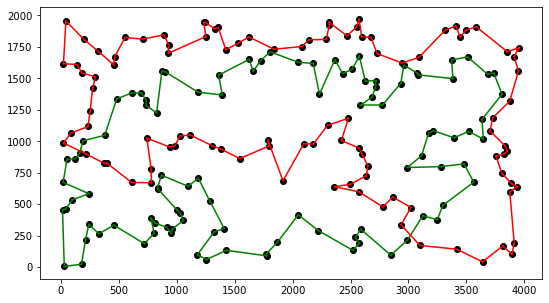

file: kroB200.tsp, search: MSLS, score: 34758.0


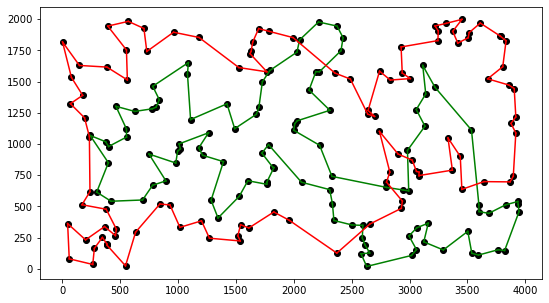

file: kroB200.tsp, perturbation: SmallPerturbation, search: ILS, with_local: True, score: 33273.0


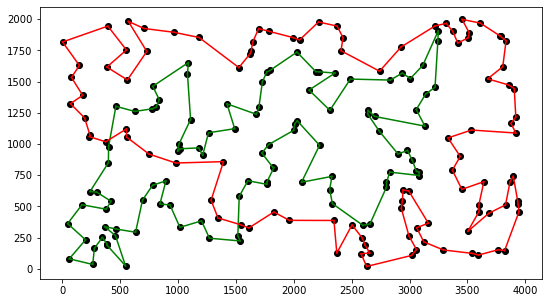

file: kroB200.tsp, perturbation: BigPerturbation, search: ILS, with_local: True, score: 30619.0


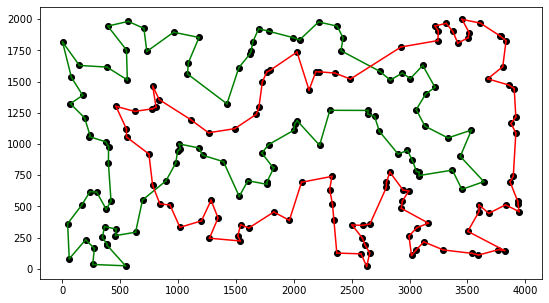

file: kroB200.tsp, perturbation: BigPerturbation, search: ILS, with_local: False, score: 30722.0


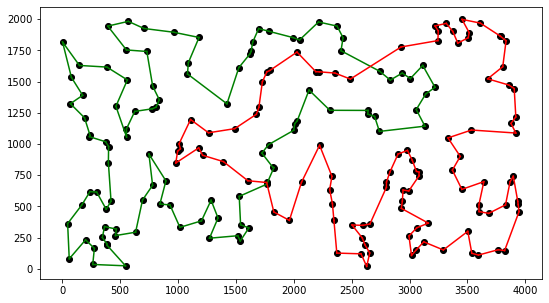

In [14]:
def compute_results():
    msls_repeats = 100
    algorithm_repeats = 10
    n = 200
    instances = [f'kroA{n}.tsp', f'kroB{n}.tsp']
    score_results = []
    time_results = []
    
    for file in instances:
        cities, coords = read_instance(file)
        solve = MSLS(cities, SearchGreedy(cities))
        times, init_solutions = zip(*mp.Pool().map(solve, [msls_repeats for _ in range(algorithm_repeats)]))
        scores = [score(cities, x) for x in init_solutions]
        
        score_results.append(dict(file=file, search="MSLS", min=int(min(scores)), mean=int(np.mean(scores)), max=int(max(scores))))
        time_results.append(dict(file=file, search="MSLS", min=float(min(times)), mean=float(np.mean(times)), max=float(max(times))))
        time_limit = np.mean(times)
        best_idx = np.argmin(scores)
        best = init_solutions[best_idx]
        print(f'file: {file}, search: MSLS, score: {scores[best_idx]}')
        plot_solution(coords, best)
        plt.show()
        
        for local_search in [ILS(cities, SmallPerturbation(n_moves=10), SearchGreedy(cities)),
                            ILS(cities, BigPerturbation(moves_fraction=0.2), SearchGreedy(cities)),
                            ILS(cities, BigPerturbation(moves_fraction=0.2), SearchGreedy(cities), with_local=False)]:
            times, solutions = zip(*mp.Pool().map(local_search, [time_limit for _ in range(algorithm_repeats)]))
            #times, solutions = zip(*[local_search(x) for x in rand_solutions])
            scores = [score(cities, x) for x in solutions]
            best_idx = np.argmin(scores)
            best = solutions[best_idx]
            print(f'file: {file}, perturbation: {type(local_search.perturbation).__name__}, search: {type(local_search).__name__}, with_local: {local_search.with_local}, score: {scores[best_idx]}')
            plt.subplots()
            plot_solution(coords, best)
            plt.show()

            score_results.append(dict(file=file, search=type(local_search).__name__+" "+type(local_search.perturbation).__name__+str("with local" if local_search.with_local else "without local"), min=int(min(scores)), mean=int(np.mean(scores)), max=int(max(scores))))
            time_results.append(dict(file=file, search=type(local_search).__name__+" "+type(local_search.perturbation).__name__+str("with local" if local_search.with_local else "without local"), min=float(min(times)), mean=float(np.mean(times)), max=float(max(times))))
        
    return pd.DataFrame(score_results), pd.DataFrame(time_results)

scores, times = compute_results()

In [17]:
scores

,file,search,min,mean,max
0,kroA200.tsp,MSLS,34812,35473,35967
1,kroA200.tsp,ILS SmallPerturbationwith local,32375,33656,34569
2,kroA200.tsp,ILS BigPerturbationwith local,30611,31068,31639
3,kroA200.tsp,ILS BigPerturbationwithout local,31065,31363,32112
4,kroB200.tsp,MSLS,34758,35679,36269
5,kroB200.tsp,ILS SmallPerturbationwith local,33273,34234,35156
6,kroB200.tsp,ILS BigPerturbationwith local,30619,31172,31802
7,kroB200.tsp,ILS BigPerturbationwithout local,30722,31491,32472


In [18]:
times

,file,search,min,mean,max
0,kroA200.tsp,MSLS,579.711402,590.883258,597.092364
1,kroA200.tsp,ILS SmallPerturbationwith local,590.890233,592.013469,593.599884
2,kroA200.tsp,ILS BigPerturbationwith local,590.886091,591.079284,591.236382
3,kroA200.tsp,ILS BigPerturbationwithout local,590.885374,590.908713,590.931451
4,kroB200.tsp,MSLS,589.237127,598.729759,608.157538
5,kroB200.tsp,ILS SmallPerturbationwith local,598.814162,599.561221,601.056977
6,kroB200.tsp,ILS BigPerturbationwith local,598.740235,598.886039,599.091312
7,kroB200.tsp,ILS BigPerturbationwithout local,598.731464,598.756848,598.784874
